<a href="https://colab.research.google.com/github/hectic97/Boostcamp-AI-Tech/blob/main/U-stage/Week7/FCN_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 : Segmentation

이번 과제에서는, Assignment 1에서 classification 문제를 풀기 위해 구성했던 CNN 모델을 **segmentation 문제를 풀기 위한 모델**로 재구성해보는 과정을 진행합니다. 모델에서 layer들을 구성하는 모듈들이 동작하는 방식을 더 잘 이해하는 시간이 되셨으면 좋겠습니다.

## Note

### Note on copying Tensor

You may use different methods for copying Tensor. Here, we list possible means you may use.

(1) y = x.detach()    
- This creates new Tensor that does not compute gradient from the original Tensor 
- You can modify such method **x.clone().detach().requires_grad_(True)** to indicate requires_grad option

(2) y = x.data
- x.data  used to get Tensor from Variable 
- **detach()** may be better, since Tensor copied from **.data** method even uses wrong gradient during update (while **detach()** outputs error on wrong gradients) 

(3) y = torch.empty_like(x).copy_(x)
- This creates new Tensor that has the same content from the original Tensor

(4) y = torch.tensor(x)

(5) y = tensor.new_tensor(x)
- You can indicates **require_grad** option with this method



### Note on assigning weight

You may use different methods for assignin weight from pre-defined Tensor. Here, we list possible means you may use.


(1) layer_.weight = torch.nn.Parameter(tensor_)

(2) layer_.wiehgt = torch.Tensor(tensor_)
	- You can use this methods during initionalization


##**Google Drive Mount**
해당 문제를 풀기 위해서는 (1) pretrained model 과 (2) 저희가 선별한 inference용도의 data가 따로 필요합니다. 과제 폴더에 해당 데이터들을 넣어드렸는데요. "드라이브에 바로가기 추가" 옵션을 활용하여 내 드라이브로 바로가기를 추가하신 후, 아래의 코드들을 돌려서 colab 작업 환경에 파일들을 잘 copy 하시기 바랍니다.

    
***Inference를 위해 사용하는 data들에는 저작권 문제가 있으니, 공지된 저작권 관련 policy를 잘 따라주셔야 합니다.***

    
혹시라도 cp가 제대로 안되는 경우 모델/데이터 로딩이 안되실 겁니다. 그럴 땐, 밑에 cp command의 source path를 알맞게 고쳐주시면 됩니다. 가령, 과제 폴더 전체를 바로가기로 추가하실 경우 source path를 ./gdrive/Mydrive/과제2/Assignment2_model_pretrinaed.pth 등으로 고쳐주시면 됩니다.

!cp <U>[source path]</U> [destination path]

In [1]:
# Mount the google drive to access the dataset.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp ./gdrive/MyDrive/Assignment2_model_pretrained.pth ./model.pth

In [6]:
!cp -R ./gdrive/MyDrive/Assignment2_data ./data

## **VGG-11 Implementation**


Let's convert VGG-11 model for image classification into semantic segmentation. You will modify the last fc layer into 1x1 conv. layer. Recall that semantic segmentation can be considered as a classification problem on each pixel of the input image data.

Here, we defined backbone model that is commonly used both for classification and segmentation tasks. Backbone of the model is composed of 5 blocks of convolutional layers (along with batch-normalization and pooling layers).

For classification, you may use fc layer for the last layer right before prediction, as seen in VGG11 (in assignment 1.1). However, this last fc layer for classification may not be appropriate for solving segmentation problem, as spatial information is lost in fc layer. In order to preserve such information, you may use convolutional layer for the last part; this idea can be seen in papers like [1].


[[1] Long et al, Fully Convolutional Networks for Semantic Segmentation, CVPR 2015](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)

### Model

The code below implements customed-VGG11 model composed of backbone and appropraite modules. Please fill in  2 **TO DO** and check the following answers with **calc_answer** functions below.


- **TO DO (1)** : You should build a layer for the semantic segmentation. (Hint: Take a look at the **forward** method)

- **TO DO (2)** : You should reshape & copy the parameter of **fc_out** layer of model for classification into defining layer (in Todo 1).

- **Hint** : You may use the functions below to fill in Todo's:    
(1) torch.reshape    
(2) torch.nn.Conv2d    
(3) torch.nn.Parameter

In [7]:
import torch
import torch.nn as nn

class VGG11BackBone(nn.Module):
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

In [8]:
class VGG11Classification(nn.Module):
  def __init__(self, num_classes = 7):
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
    self.gap      = nn.AdaptiveAvgPool2d(1)
    self.fc_out   = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.pool5(x)

    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

In [91]:
class VGG11Segmentation(nn.Module):
  def __init__(self, num_classes = 7):
    super(VGG11Segmentation, self).__init__()

    self.backbone = VGG11BackBone()
    
    '''==========================================================='''
    '''======================== TO DO (1) ========================'''
    self.conv_out = nn.Conv2d(512, num_classes, kernel_size = 1)



    '''======================== TO DO (1) ========================'''
    '''==========================================================='''
  
    self.upsample = torch.nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)

  def forward(self, x):
    # print(x.shape)
    x = self.backbone(x)
    # print(x.shape)
    x = self.conv_out(x)
    # print(x.shape)
    x = self.upsample(x)
    assert x.shape == (1, 7, 224, 224)

    return x

  def copy_last_layer(self, fc_out):
    """
    Copy last pre-trained fully-connected layer of classification model
    into self.conv_out layer of segmentation model in appropriate shape

    Keyword arguments:
    fc_out: the fc layer of classification model (with shape of (7, 512))
    """

    '''==========================================================='''
    '''======================== TO DO (2) ========================'''
    
    self.conv_out.weight = torch.nn.Parameter(torch.reshape(w_fc.weight.detach(),(7,512,1,1)))

    
    '''======================== TO DO (2) ========================'''
    '''==========================================================='''
    assert self.conv_out.weight[0][0] == fc_out.weight[0][0]
    
    return 

In [92]:
test_input = torch.randn((1, 3, 224, 224))

modelC = VGG11Classification()
out = modelC(test_input)
print(out.shape)

modelS = VGG11Segmentation()
out = modelS(test_input)
print(out.shape)

torch.Size([1, 7])
torch.Size([1, 7, 224, 224])


### Dataloader

This dataloader is slightly modified from assignment1.1, since we do not use large train/valid data, but only few images for inference on segmentation problem.

In [93]:
# Dataset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import os
import cv2
import numpy as np
from glob import glob

class MaskDataset(Dataset):
  def __init__(self, data_root, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list = glob(os.path.join(data_root, '*.jpg'))
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
  
    # Image Loading
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.

    if self.transform:
      img = self.transform(img)

    # Ground Truth
    label = self._get_class_idx_from_img_name(img_path)

    return img, label
  def __len__(self):
    return self.len
  
  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path)

    if 'normal' in img_name:
      return 0
    elif 'mask1' in img_name:
      return 1
    elif 'mask2' in img_name:
      return 2
    elif 'mask3' in img_name:
      return 3
    elif 'mask4' in img_name:
      return 4
    elif 'mask5' in img_name:
      return 5
    elif 'incorrect_mask' in img_name:
      return 6
    else:
      raise ValueError("%s is not a valid filename. Please change the name of %s." % (img_name, img_path))

## Weight Reshaping

### Loading model

In [94]:
## Model Loading
model_root = './model.pth'

modelC = VGG11Classification()
modelC.load_state_dict(torch.load(model_root))

<All keys matched successfully>

### Copy weight to reshape

Here, we copy the last layer of pretrained model for classification task into new model for segmentation task using 1x1 fully-convolutional layer. In order to fit into the new model, the weight should be reshaped.

In [95]:
## Copy Weight
modelS  = VGG11Segmentation()
modelS.backbone = modelC.backbone

w_fc = modelC.fc_out
modelS.copy_last_layer(w_fc)

### Test

You may test on your segmentation model with prepared data with below cells.

The below figure is an example result. You may check that the model is focusing on the part around the mask in the image, so can extract mask segmentation.

<img src='https://drive.google.com/uc?id=1IFw0QT2zbr1txEQXaTBGuRGtgXBm8ruP'  width="224">

In [96]:
# Image Loading
data_root = './data'
input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
batch_size = 1

test_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

tensor([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


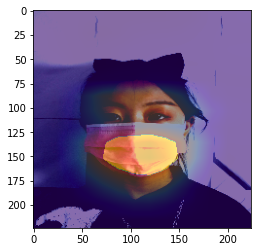

tensor([3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


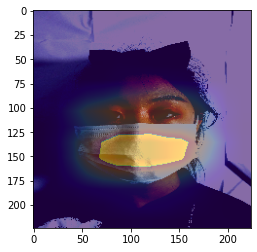

tensor([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


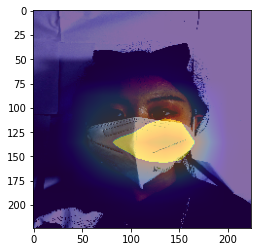

tensor([5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


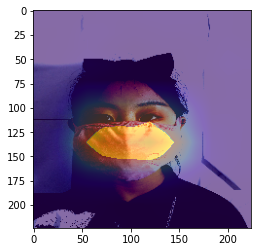

tensor([2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


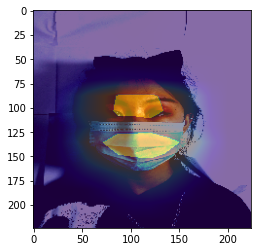

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0])


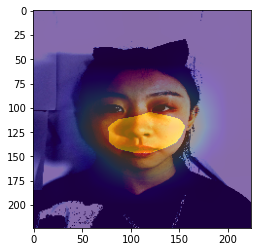

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([6])


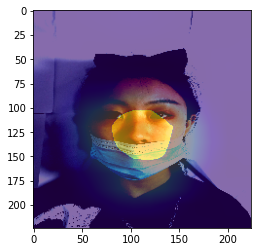

In [98]:
import matplotlib

# Test on Segmentation
modelS.cuda().float()
modelS.eval()

for iter, (img, label) in enumerate(test_loader):
  img = img.float().cuda()
  print(label)
  # Inference for Semantic Segmentation
#   print(img.shape)
  res = modelS(img)[0]

  heat = res[label[0]]
  resH = heat.cpu().detach().numpy()
  heatR, heatC = np.where(resH > np.percentile(resH, 95))
  
  seg = torch.argmax(res, dim=0)
  seg = seg.cpu().detach().numpy()
  [segR, segC] = np.where(seg == np.int(label[0].cpu()))

  resS = np.zeros((224,224))
  for i, r in enumerate(heatR):
    c = heatC[i]
    if (r in segR) and (c in segC):
      resS[r,c] = 1
  
  want_to_check_heat_map_result = True

  # Plot segmentation result
  matplotlib.pyplot.imshow(img[0].cpu().permute(1, 2, 0))
  if want_to_check_heat_map_result:
    matplotlib.pyplot.imshow(resH, cmap='jet', alpha=0.3)
  matplotlib.pyplot.imshow(resS, alpha=0.4)
  matplotlib.pyplot.show()

#### **Disccusion**

You may also check heatmap result with **want_to_check_heat_map_result** flag. This might be helpful to notice why model is showing such results.

## Answers

The cells below implements simple function that compute the answer for the problem you will be submit on edwith. With proper code filled, you will get an integer answer. 

In [83]:
def calc_answer_2_1(model):
  """
  Compute the size of conv_out layer in modified model for solving semantic segmentation task
  """
  answer  = 0

  size = model.conv_out.weight.size()
  for s in size:
    answer += s
  
  return answer


print(f"The answer for problem (1) is {calc_answer_2_1(modelS)}")

The answer for problem (1) is 521


In [84]:
def calc_answer_2_2(model, dataloader):
  """
  Compute the overall sum of data in row of segmentation result, from input image data with label of 6
  """
  answer = 0

  for iter, (img, label) in enumerate(test_loader):
    if label == 6:
      img = img.float().cuda()
      res = modelS(img)[0]

      heat = res[label[0]]
      resH = heat.cpu().detach().numpy()
      heatR, heatC = np.where(resH > np.percentile(resH, 95))
      
      seg = torch.argmax(res, dim=0)
      seg = seg.cpu().detach().numpy()
      [segR, segC] = np.where(seg == np.int(label[0].cpu()))

      resS = np.zeros((224,224))
      for i, r in enumerate(heatR):
        c = heatC[i]
        if (r in segR) and (c in segC):
          answer += r

  return answer

print(f"The answer for problem (2) is {calc_answer_2_2(modelS, test_loader)}")

The answer for problem (2) is 320239
